In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

rxdb_root = "/mnt/home/ssledzieski/GitHub/Dyna-1/data/RelaxDB_datasets"
with open(f"{rxdb_root}/RelaxDB_with_other_metrics_22jan2025.json", "r") as f:
    rxdb = json.load(f)
relaxdb = pd.DataFrame.from_dict(rxdb)

In [4]:
plt.rcParams.update(
    {
        # "axes.prop_cycle": "cycler('color', ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9'])",
        "axes.prop_cycle": "cycler('color', ['#537EBA', '#FF9300', '#81AD4A', '#FF4115', '#FFD53E', '#1D2954'])",  # simons foundation
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 16,
        "figure.autolayout": False,
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
        "svg.fonttype": "none",
    }
)

In [2]:
def get_structure(prot_id, root_db = "/mnt/home/ssledzieski/GitHub/Dyna-1/data/RelaxDB_datasets/output_structures"):
    prot_directory = Path(f"{root_db}/{prot_id}")
    pdb_file = next(prot_directory.glob("*.pdb"))
    return pdb_file

def get_sequence(prot_id, relax_df = relaxdb):
    # Get the sequence from the RelaxDB dataframe
    seq = relax_df.loc[prot_id, "sequence"]
    return seq

In [3]:
import torch
from torch.nn.functional import softmax
from rocketshp import RocketSHP, load_sequence, load_structure
from rocketshp.plot import plot_predictions
from biotite.structure.io import pdb

# Set compute device
device = torch.device("cuda:0")

# Load the model (will download if not present)
model = RocketSHP.load_from_checkpoint("v1").to(device)

rxdb_rocketshp = {}
for protein_id in tqdm(relaxdb.index):
    try:
        seq_features = load_sequence(get_sequence(protein_id), device=device)
        structure = pdb.PDBFile.read(get_structure(protein_id)).get_structure()
        struct_features = load_structure(structure, device=device)
    except Exception as e:
        continue
    with torch.no_grad():
        dynamics_pred = model({"seq_feats": seq_features, "struct_feats": struct_features})

    # Access prediction results
    rmsf = dynamics_pred["rmsf"].squeeze().cpu().numpy()
    gcc_lmi = dynamics_pred["gcc_lmi"].squeeze().cpu().numpy()
    ca_dist = dynamics_pred["ca_dist"].squeeze().cpu().numpy()
    shp = softmax(dynamics_pred["shp"].squeeze(), dim=1).cpu().numpy()

    # Visualize results
    # plot_predictions(rmsf, gcc_lmi, shp, protein_id, f"rocketshp_{protein_id}.png")

    rxdb_rocketshp[protein_id] = {
        "rmsf": rmsf,
        "gcc_lmi": gcc_lmi,
        "ca_dist": ca_dist,
        "shp": shp
    }

  0%|          | 0/133 [00:00<?, ?it/s]

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/pretrained.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/

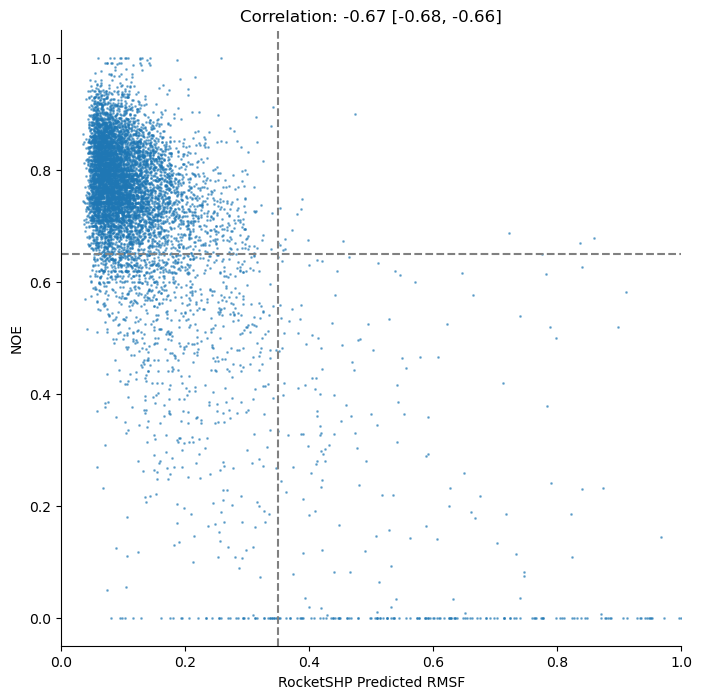

In [203]:
from scipy.stats import pearsonr
from torch.nn.functional import relu

# all rmsf and noe in one list each
rmsf_all = []
noe_all = []
for protein_id in rxdb_rocketshp:
    # rmsf_all.append(torch.nn.functional.relu(torch.from_numpy(1 - rxdb_rocketshp[protein_id]["rmsf"])))
    # noe_all.append(relaxdb.loc[protein_id, "NOE"])
    rmsf_all.append(rxdb_rocketshp[protein_id]["rmsf"])
    noe_all.append(relaxdb.loc[protein_id, "NOE"])
rmsf_all = np.concatenate(rmsf_all)
noe_all = np.concatenate(noe_all)

rmsf_nonan = []
noe_nonan = []
for i,j in zip(rmsf_all, noe_all):
    if j is not None:
        rmsf_nonan.append(i)
        noe_nonan.append(j)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(rmsf_nonan, noe_nonan, s = 1, alpha = 0.5)
# compute the correlation coefficient
result = pearsonr(rmsf_nonan, noe_nonan)
correlation, pval = result[0], result[1]
confidence = result.confidence_interval()

# plot line of best fit
plt.axhline(y=0.65, color="gray", linestyle="--")
plt.axvline(x=0.35, color="gray", linestyle="--")
plt.xlabel("RocketSHP Predicted RMSF")
plt.xlim(0, 1)
plt.ylabel("NOE")
sns.despine()
plt.title(f"Correlation: {correlation:.2f} [{confidence[0]:.2f}, {confidence[1]:.2f}]")
plt.savefig(Path(rxdb_root) / "rocketshp_rmsf_noe.svg")
plt.show()

In [269]:
from torch.nn.functional import relu

# compute MSE of the two
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(relu(1 - torch.tensor(rmsf_nonan)), noe_nonan))
print(f"RMSE: {rmse:.2f}")

RMSE: 0.19


Accuracy: 0.87


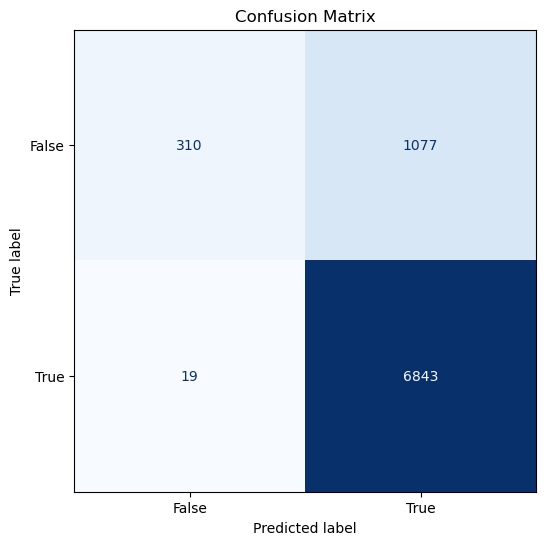

Precision: 0.86
Recall: 1.00


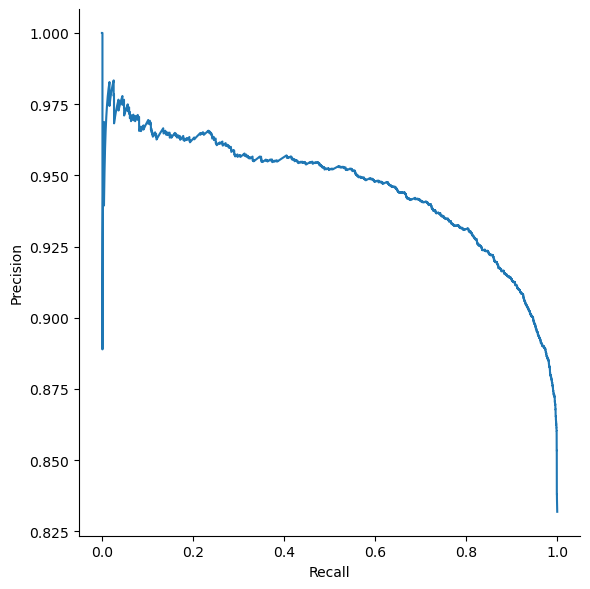

In [283]:
# compute accuracy with binary threshold of 0.65
from sklearn.metrics import accuracy_score
def binary_threshold(x, threshold=0.65):
    return [1 if i > threshold else 0 for i in x]

y_pred = relu(1 - torch.tensor(rmsf_nonan))
y_true = binary_threshold(noe_nonan, threshold=0.65)
accuracy = accuracy_score(y_true, binary_threshold(y_pred, threshold=0.65))
print(f"Accuracy: {accuracy:.2f}")

# show confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true, binary_threshold(y_pred, threshold=0.65))
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.savefig(Path(rxdb_root) / "rocketshp_relaxdb_confusion_matrix.svg")
plt.show()

# compute precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true, binary_threshold(y_pred, threshold=0.65))
recall = recall_score(y_true, binary_threshold(y_pred, threshold=0.65))
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# plot AUPR curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(y_true, y_pred)
aupr = average_precision_score(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(recall, precision, label=f'AUPR: {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
sns.despine()
plt.tight_layout()
plt.savefig(Path(rxdb_root) / "rocketshp_relaxdb_aupr.svg")



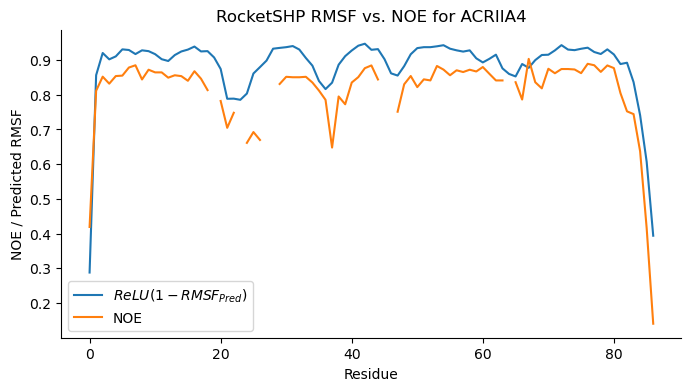

In [ ]:


protein_id = "ACRIIA4"

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(relu(torch.from_numpy(1 - rxdb_rocketshp[protein_id]["rmsf"])), label="$ReLU(1 - RMSF_{Pred})$")
ax.plot(relaxdb.loc[protein_id, "NOE"], label="NOE")
plt.legend()
plt.xlabel("Residue")
plt.ylabel("NOE / Predicted RMSF")
plt.title(f"RocketSHP RMSF vs. NOE for {protein_id}")
sns.despine()
plt.savefig(Path(rxdb_root) / f"rocketshp_rmsf_noe_{protein_id}.svg")
plt.show()

In [ ]:
# load acriia4 pdb structure and write NOE into B factor column
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.io as strucio
import numpy as np

protein_id = "ACRIIA4"

noe = relaxdb.loc[protein_id, "NOE"]
rmsf = relu(torch.from_numpy(1 - rxdb_rocketshp[protein_id]["rmsf"]))

pdb_file = pdb.PDBFile.read(get_structure(protein_id))
structure = pdb_file.get_structure()[0]

# Assuming 'noe' is an array with values for each residue
# Some values might be None
# First, get the residue indices
residue_ids = np.unique(structure.res_id)

# Check if dimensions match
if len(noe) != len(residue_ids):
    print(f"Warning: Number of values in noe array ({len(noe)}) doesn't match number of residues ({len(residue_ids)})")

# Create a new array for B-factors (one value per atom, not per residue)
# Initialize with zeros or another default value
b_factors = np.zeros(structure.array_length())

# Loop through each residue and assign B-factors to its atoms
for i, res_id in enumerate(residue_ids):
    if i >= len(noe):  # In case noe array is shorter than number of residues
        break
        
    # Get mask for all atoms in this residue
    residue_mask = structure.res_id == res_id
    
    # Handle None values
    if noe[i] is None:
        # Set to a default value (e.g., 0.0 or -1.0 to distinguish them)
        b_factors[residue_mask] = 0.0
    else:
        # Assign the noe value to all atoms in this residue
        b_factors[residue_mask] = noe[i]

structure.add_annotation("b_factor", dtype=float)
structure.b_factor = np.array(b_factors)
strucio.save_structure(f"{rxdb_root}/{protein_id}_noe.pdb", structure)

In [ ]:
# load acriia4 pdb structure and write NOE into B factor column
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.io as strucio
import numpy as np

protein_id = "ACRIIA4"

rmsf = relu(torch.from_numpy(1 - rxdb_rocketshp[protein_id]["rmsf"]))

pdb_file = pdb.PDBFile.read(get_structure(protein_id))
structure = pdb_file.get_structure()[0]

# Assuming 'noe' is an array with values for each residue
# Some values might be None
# First, get the residue indices
residue_ids = np.unique(structure.res_id)

# Check if dimensions match
if len(rmsf) != len(residue_ids):
    print(f"Warning: Number of values in noe array ({len(rmsf)}) doesn't match number of residues ({len(residue_ids)})")

# Create a new array for B-factors (one value per atom, not per residue)
# Initialize with zeros or another default value
b_factors = np.zeros(structure.array_length())

# Loop through each residue and assign B-factors to its atoms
for i, res_id in enumerate(residue_ids):
    if i >= len(rmsf):  # In case noe array is shorter than number of residues
        break
        
    # Get mask for all atoms in this residue
    residue_mask = structure.res_id == res_id
    
    # Handle None values
    if noe[i] is None:
        # Set to a default value (e.g., 0.0 or -1.0 to distinguish them)
        b_factors[residue_mask] = 0.0
    else:
        # Assign the noe value to all atoms in this residue
        b_factors[residue_mask] = rmsf[i]

structure.add_annotation("b_factor", dtype=float)
structure.b_factor = np.array(b_factors)
strucio.save_structure(f"{rxdb_root}/{protein_id}_rmsf.pdb", structure)

# pymol commands

```
translate [40, 0, 0], ACRIIA4_rmsf
spectrum b, red_white_blue, minimum=0.65, maximum=1.0
select zero_bfactors, b < 0.001 and b > -0.001
color gray, zero_bfactors
```